In [8]:
import boto3
from braket.aws import AwsDevice
from braket.circuits import Circuit

from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from timeit import default_timer as timer
from math import sqrt

In [2]:
device = LocalSimulator()

bell = Circuit().h(0).cnot(0, 1)
task = device.run(bell, shots=10)
print(task.result().measurement_counts)
# get device name
device_name = device.name

# show the properties of the device 
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']
# Note: This field also exists for other devices like the QPUs
print('Quantum Gates supported by {}:\n {}'.format(device_name, device_operations))

Counter({'11': 6, '00': 4})
Quantum Gates supported by StateVectorSimulator:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cv', 'cy', 'cz', 'ecr', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


In [53]:
from braket.circuits import circuit, Circuit, Gate, Moments
from braket.circuits.instruction import Instruction
from braket.aws import AwsQuantumTask, AwsDevice
from braket.devices import LocalSimulator
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np

## Grover Algorithm

In [158]:
import itertools
# Helper function to build C-C-Z gate
@circuit.subroutine(register=True)
def ccz():
    """
    implementation of three-qubit gate CCZ
    """
    # define three-qubit CCZ gate
    ccz_gate = np.eye(n_elem, dtype=complex)
    ccz_gate[n_elem-1, n_elem-1] = -1.+0.j
    
    # instantiate circuit object
    circ = Circuit()
    
    # add CCZ gate
    circ.unitary(matrix=ccz_gate, targets=targets)
    
    return circ

n_qub = 7
n_elem = 2**n_qub
targets = [x for x in range(0, n_qub)]

test = list(itertools.product([0, 1], repeat=n_qub))
ora = ["".join(map(str, test[i]))  for i in range(0,n_elem)]
oracle_sim = {
    ora[i]: Circuit().x(np.where(np.array(test[i]) < 1)[0]).ccz().x(np.where(np.array(test[i]) < 1)[0])  for i in range(0,n_elem)
}

# helper function for initialization
def initialize(n_qubits=n_qub):
    """
    function to apply hadamard to all qubits
    """
    # Initialize with superposition
    circ = Circuit();
    circ.h(np.arange(n_qubits))
    #print(circ)
    return circ


# helper function for phase oracle
def oracle(item):
    """
    function to apply oracle for given target item
    """
    # instantiate circuit object
    circ = Circuit()
    
    # add oracle
    circ.add_circuit(oracle_sim[item])
    
    return circ


# helper function for amplification
def amplify(n_qubits=n_qub):
    """
    function for amplitude amplification
    """
    # instantiate circuit object
    circ = Circuit()
    
    # Amplification
    circ.h(np.arange(n_qubits))
    circ.add_circuit(oracle_sim[ora[0]])
    circ.h(np.arange(n_qubits))
    
    return circ


# helper function for grover algorithm
def grover(item, n_qubits=n_qub, n_reps=1):
    """
    function to put together individual modules of Grover algorithm
    """
    # initialize
    grover_circ = initialize()
    # oracle and amplify
    for ii in range(n_reps):
        # get oracle
        or_circ = oracle(item)
        grover_circ.add(or_circ)
        # amplify
        amplification = amplify()
        grover_circ.add(amplification)
    
    return grover_circ

In [162]:
# Function to run quantum task, check the status thereof, and collect results
task=None
def get_result(circ):
    
    # get number of qubits
    num_qubits = circ.qubit_count

    # specify desired results_types
    circ.probability()
    
    start = timer()

    # submit task: define task (asynchronous)
    task = device.run(circ, shots=1000)

    # Get ID of submitted task
    task_id = task.id
#     print('Task ID :', task_id)

    # Wait for job to complete
    status_list = []
    status = task.state()
    status_list += [status]
    print('Status:', status)

    # Only notify the user when there's a status change
    while status != 'COMPLETED':
        status = task.state()
        if status != status_list[-1]:
            print('Status:', status)
        status_list += [status]

    # get result
    result = task.result()
    end = timer()
    
    print("Task Summary")
    print(f"Time: {end - start} seconds")
    times.append(round(end - start, 4))

    # get metadata
    metadata = result.task_metadata

    # get output probabilities
    probs_values = result.values[0]

    # get measurement results
    measurement_counts = result.measurement_counts

    # print measurement results
    print('measurement_counts:', measurement_counts)

    # bitstrings
    format_bitstring = '{0:0' + str(num_qubits) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # plot probabalities
    plt.figure(figsize=(14, 7))
    plt.bar(bitstring_keys, probs_values);
    plt.xlabel('bitstrings');
    plt.ylabel('probability');
    plt.xticks(rotation=90);
    plt.show()
    plt.savefig('simulator7.png', dpi=700)
    
    return measurement_counts

start grover
end grover
T  : |0|1|2|3|4|5|6|
                    
q0 : -H-U-H-X-U-X-H-
        |     |     
q1 : -H-U-H-X-U-X-H-

T  : |0|1|2|3|4|5|6|
get results
Status: COMPLETED
Task Summary
Time: 0.04135688099995605 seconds
measurement_counts: Counter({'11': 1000})


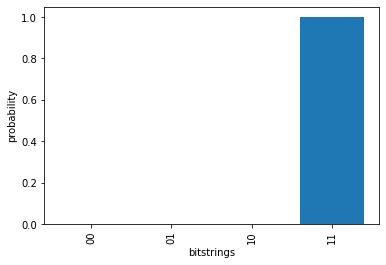

{}


<Figure size 432x288 with 0 Axes>

In [148]:
n_qub = 2
n_elem = 2**n_qub
targets = [x for x in range(0, n_qub)]

# set up the local simulator
device = LocalSimulator()

# Select item to find. Let's start with '111' for now
item = "11"
times=[]

# get Grover circuit
circ = grover(item, n_reps=round(sqrt(n_qub)))

# print circuit
print(circ)

# Measurement
from braket.tracking import Tracker
t = Tracker().start()
counts = get_result(circ)
print(t.quantum_tasks_statistics())

Searching item:  101
T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|
                                               
q0 : -H---U-H-X---U-X-H---U--H--X-----U--X--H--
          |       |       |           |        
q1 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--
          |       |       |           |        
q2 : -H---U-H-X---U-X-H---U--H--X-----U--X--H--

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|
Status: COMPLETED
Task Summary
Time: 0.0881417179998607 seconds
measurement_counts: Counter({'101': 954, '111': 11, '011': 7, '000': 7, '110': 6, '010': 6, '001': 5, '100': 4})


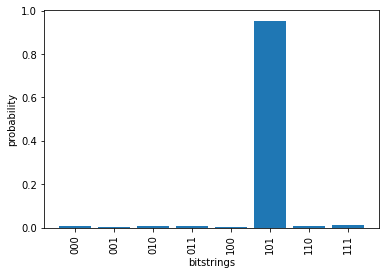

{}


<Figure size 432x288 with 0 Axes>

In [152]:
n_qub = 3
n_elem = 2**n_qub
targets = [x for x in range(0, n_qub)]

# set up the local simulator
device = LocalSimulator()

# Select item to find. Let's start with '111' for now
item = "101"
times=[]
print("Searching item: ", item)

# get Grover circuit
circ = grover(item, n_reps=round(sqrt(n_qub)))

# print circuit
print(circ)

# Measurement
from braket.tracking import Tracker
t = Tracker().start()
counts = get_result(circ)
print(t.quantum_tasks_statistics())

Searching item:  1101
T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|
                                               
q0 : -H---U-H-X---U-X-H---U--H--X-----U--X--H--
          |       |       |           |        
q1 : -H---U-H-X---U-X-H---U--H--X-----U--X--H--
          |       |       |           |        
q2 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--
          |       |       |           |        
q3 : -H---U-H-X---U-X-H---U--H--X-----U--X--H--

T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|
Status: COMPLETED
Task Summary
Time: 0.18695460700018884 seconds
measurement_counts: Counter({'1101': 902, '0001': 12, '0101': 11, '1100': 8, '1011': 7, '1001': 7, '1010': 7, '1110': 6, '1000': 6, '0000': 6, '0111': 5, '0010': 5, '0100': 5, '0011': 5, '0110': 4, '1111': 4})


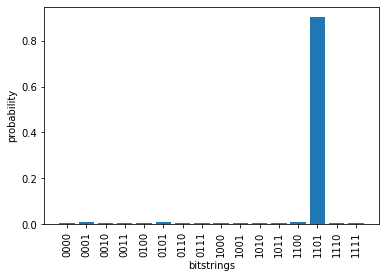

{}


<Figure size 432x288 with 0 Axes>

In [154]:
n_qub = 4
n_elem = 2**n_qub
targets = [x for x in range(0, n_qub)]

# set up the local simulator
device = LocalSimulator()

# Select item to find. Let's start with '111' for now
item = "1101"
times=[]
print("Searching item: ", item)

# get Grover circuit
circ = grover(item, n_reps=round(sqrt(n_qub)))

# print circuit
print(circ)

# Measurement
from braket.tracking import Tracker
t = Tracker().start()
counts = get_result(circ)
print(t.quantum_tasks_statistics())

Searching item:  0101100
T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
                                                                       
q0 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--
          |       |       |           |           |           |        
q1 : -H---U-H-X---U-X-H---U--H--X-----U--X--H-----U--H--X-----U--X--H--
          |       |       |           |           |           |        
q2 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--
          |       |       |           |           |           |        
q3 : -H---U-H-X---U-X-H---U--H--X-----U--X--H-----U--H--X-----U--X--H--
          |       |       |           |           |           |        
q4 : -H---U-H-X---U-X-H---U--H--X-----U--X--H-----U--H--X-----U--X--H--
          |       |       |           |           |           |        
q5 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--
          |       |       |           |

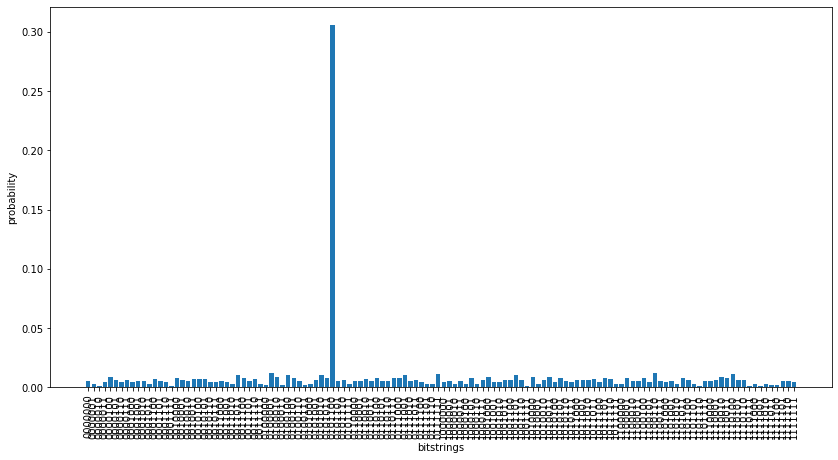

{}


<Figure size 432x288 with 0 Axes>

In [163]:
n_qub = 7
n_elem = 2**n_qub
targets = [x for x in range(0, n_qub)]

# set up the local simulator
device = LocalSimulator()

# Select item to find. Let's start with '111' for now
item = "0101100"
times=[]
print("Searching item: ", item)

# get Grover circuit
circ = grover(item, n_reps=round(sqrt(n_qub)))

# print circuit
print(circ)

# Measurement
from braket.tracking import Tracker
t = Tracker().start()
counts = get_result(circ)
print(t.quantum_tasks_statistics())

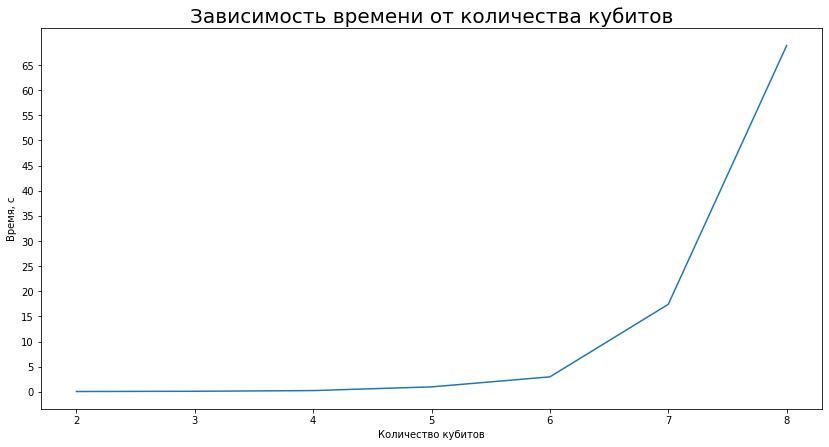

In [86]:
t1 = np.arange(2.0, 9.0, 1.0)
t2 = np.arange(0.0, 70, 5.0)
plt.figure(figsize=(14, 7))
plt.plot(t1, times)
plt.xticks([2, 3, 4, 5, 6, 7, 8])
plt.yticks(t2)
plt.title('Зависимость времени от количества кубитов', fontsize=20)
plt.xlabel("Количество кубитов")
plt.ylabel("Время, с")
plt.show()

## IonQ

In [6]:
# set up the local simulator
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

# Select item to find. Let's start with '111' for now
item = "1001001"

# get Grover circuit
print("start grover")
circ = grover(item, n_reps=5)
print("end grover")

# print circuit
print(circ)

# Measurement
print("get results")
from braket.tracking import Tracker
t = Tracker().start()
counts = get_result(circ)
print(t.quantum_tasks_statistics())

start grover
end grover
T  : |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|
                                                                                                                       
q0 : -H---U-H-X---U-X-H---U--H--X-----U--X--H-----U--H--X-----U--X--H-----U--H--X-----U--X--H-----U--H--X-----U--X--H--
          |       |       |           |           |           |           |           |           |           |        
q1 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--
          |       |       |           |           |           |           |           |           |           |        
q2 : -H-X-U-X-H-X-U-X-H-X-U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--X--U--X--H--
          |       |       |           |           |           |           |           |           |           |        
q3 : -H---U-H-X-

AccessDeniedException: An error occurred (AccessDeniedException) when calling the CreateQuantumTask operation: Account 576588997085 is not permitted to access AWS Braket resources.

In [ ]:
import random

# set up the local simulator
device = LocalSimulator()

item = str(random.randint(0,1))
n_qub = 2
n_elem = 2**n_qub
times = []

for jj in range(2, 8):
    print("Number of qubits: ", jj)
    n_qub = jj
    n_elem = 2**n_qub
    targets = [x for x in range(0, n_qub)]
    item += str(random.randint(0,1))
    print("Searching item: ", search_item)
    
    test = list(itertools.product([0, 1], repeat=n_qub))
    ora = ["".join(map(str, test[i]))  for i in range(0,n_elem)]
    oracle_sim = {
        ora[i]: Circuit().x(np.where(np.array(test[i]) < 1)[0]).ccz().x(np.where(np.array(test[i]) < 1)[0])  for i in range(0,n_elem)
    }
    print(ora)
    circ = grover(item, n_reps=round(sqrt(n_qub)))

    # print circuit
    print(circ)

    # Measurement
    from braket.tracking import Tracker
    counts = get_result(circ)
    print("\n\n")

print(times)